<a href="https://colab.research.google.com/github/gaganWanjari/Pytorch/blob/main/experimentTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms



In [ ]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 38.47 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.
mv: cannot move 'pytorch-deep-learning/going_modular' to './going_modular': Directory not empty


In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def set_seeds(seed: int= 42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [ ]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source : str, destination: str, remove_source: bool  = True) -> Path:
  data_path = Path("data/")
  image_path = data_path / destination
  if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
  else:
    image_path.mkdir(parents = True, exist_ok = True)
    target_file = Path(source).name
    with open(data_path/target_file, "wb") as f:
      request = requests.get(source)
      f.write(request.content)

    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      zip_ref.extractall(image_path)
    if remove_source:
      os.remove(data_path/target_file)

image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",destination = "pizza_steak_sushi")


[INFO] data/pizza_steak_sushi directory exists, skipping download.


NameError: name 'f' is not defined

In [ ]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"


normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, manual_transforms, batch_size = 42)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bd393ca3af0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s]


In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

set_seeds()

model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace= True),
    nn.Linear(in_features= 1280, out_features= len(class_names), bias = True).to(device)
)

In [ ]:
from torchinfo import summary


ModuleNotFoundError: No module named 'torchinfo'

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Import train() function from:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)

        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()

    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [ ]:
set_seeds()
results = train(model,train_dataloader= train_dataloader, test_dataloader=test_dataloader,optimizer= optimizer,  loss_fn = loss_fn,epochs= 5, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0759 | train_acc: 0.4262 | test_loss: 0.9261 | test_acc: 0.5779
Epoch: 2 | train_loss: 0.8825 | train_acc: 0.7310 | test_loss: 0.8038 | test_acc: 0.6558
Epoch: 3 | train_loss: 0.7655 | train_acc: 0.7960 | test_loss: 0.6844 | test_acc: 0.8496
Epoch: 4 | train_loss: 0.6601 | train_acc: 0.8421 | test_loss: 0.5934 | test_acc: 0.9134
Epoch: 5 | train_loss: 0.5959 | train_acc: 0.8817 | test_loss: 0.5424 | test_acc: 0.9134


In [ ]:
results

{'train_loss': [1.0758857528368633,
  0.8825159072875977,
  0.7655104398727417,
  0.6600618461767832,
  0.5958927671114603],
 'train_acc': [0.4261904761904762,
  0.730952380952381,
  0.796031746031746,
  0.8420634920634921,
  0.8817460317460318],
 'test_loss': [0.9260643720626831,
  0.8038231432437897,
  0.6843919157981873,
  0.5933516919612885,
  0.5424352586269379],
 'test_acc': [0.577922077922078,
  0.6558441558441558,
  0.8495670995670996,
  0.9134199134199135,
  0.9134199134199135]}

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir runs

In [ ]:
def create_writer(experiment_name: str, model_name: str, extra: str = None) -> torch.utils.tensorboard.writer.SummaryWriter():
  from datetime import datetime
  import os

  timestamp = datetime.now().strftime("%Y-%m-%d")
  if extra:
    log_dir = os.path.joinlog_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

  print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
  return SummaryWriter(log_dir=log_dir)

In [ ]:
example_writer = create_writer(experiment_name="data_10_percent", model_name="effnetb0", extra = "5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2024-04-27/data_10_percent/effnetb0/5_epochs...


In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results


In [ ]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [ ]:
# Setup training directory paths
train_dir_10_percent = "data/pizza_steak_sushi/train"
train_dir_20_percent = "data/pizza_steak_sushi_20_percent/train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = "data/pizza_steak_sushi/test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [ ]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [ ]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [ ]:
import torchvision
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 145MB/s]


In [ ]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  for param in model.features.parameters():
    param.requires_grad = False

  set_seeds()

  model.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features = 1280, out_features=OUT_FEATURES)).to(device)
  model.name = "effnetb0"
  return model

def create_effnetb2():
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights = weights).to(device)

  for param in model.features.parameters():
    param.requires_grad = False
  set_seeds()

  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3),
      nn.Linear(in_features=1408, out_features= OUT_FEATURES)).to(device)
  model.name = "effnetb2"
  return model


In [ ]:
effnetb0 = create_effnetb0()

In [ ]:
effnetb2 = create_effnetb2()

In [ ]:
num_epochs = [5,10]
models = ["effnetb0", "effnetb2"]

train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [ ]:
%%time
from going_modular.going_modular.utils import save_model

set_seeds(42)

experiment_number = 0
for dataloader_name, train_dataloader in train_dataloaders.items():
  for epochs in num_epochs:
    for model_name in models:
      experiment_number += 1
      print(f"Exp No:{experiment_number}")
      print(f"Model:{model_name}")
      print(f"DataLoader:{dataloader_name}")
      print(f"Number of epochs:{epochs}")
      if model_name == "effnetb0":
        model = create_effnetb0()
      else:
        model = create_effnetb2()
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
      train(model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer = optimizer, loss_fn  = loss_fn, epochs = epochs, device = device, writer = create_writer(experiment_name= dataloader_name, model_name=model_name, extra=f"{epochs}_epochs"))
      save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model, target_dir = "models", model_name = save_filepath)
      print("-"*50+"\n")


Exp No:1
Model:effnetb0
DataLoader:data_10_percent
Number of epochs:5
[INFO] Created SummaryWriter, saving to: runs/2024-04-27/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9220 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8139 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8100 | train_acc: 0.6445 | test_loss: 0.7176 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5677 | test_acc: 0.8864
[INFO] Saving model to: models/effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

Exp No:2
Model:effnetb2
DataLoader:data_10_percent
Number of epochs:5
[INFO] Created SummaryWriter, saving to: runs/2024-04-27/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7150 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873
[INFO] Saving model to: models/effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

Exp No:3
Model:effnetb0
DataLoader:data_10_percent
Number of epochs:10
[INFO] Created SummaryWriter, saving to: runs/2024-04-27/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9220 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8139 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8100 | train_acc: 0.6445 | test_loss: 0.7176 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.5677 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5612 | train_acc: 0.8984 | test_loss: 0.5950 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5574 | train_acc: 0.7930 | test_loss: 0.5567 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4702 | train_acc: 0.9492 | test_loss: 0.5177 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7773 | test_loss: 0.5095 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4795 | train_acc: 0.8242 | test_loss: 0.4640 | test_acc: 0.9072
[INFO] Saving model to: models/effnetb0_data_10_percent_10_epochs.pth
---------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7150 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6325 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6126 | train_acc: 0.8008 | test_loss: 0.6404 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6200 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6227 | test_acc: 0.8466
Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models/effnetb2_data_10_percent_10_epochs.pth
---------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6544 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5798 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4575 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4458 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3908 | test_acc: 0.9176
[INFO] Saving model to: models/effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

Exp No:6
Model:effnetb2
DataLoader:data_20_percent
Number of epochs:5
[INFO] Created SummaryWriter, saving to: runs/2024-04-27/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7768 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4462 | test_acc: 0.9489
[INFO] Saving model to: models/effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

Exp No:7
Model:effnetb0
DataLoader:data_20_percent
Number of epochs:10
[INFO] Created SummaryWriter, saving to: runs/2024-04-27/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6544 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5798 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4575 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4458 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3908 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3705 | train_acc: 0.8854 | test_loss: 0.3568 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3551 | train_acc: 0.9250 | test_loss: 0.3186 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8938 | test_loss: 0.3349 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.2972 | train_acc: 0.9396 | test_loss: 0.3093 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3620 | train_acc: 0.8479 | test_loss: 0.2780 | test_acc: 0.9072
[INFO] Saving model to: models/effnetb0_data_20_percent_10_epochs.pth
---------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5521 | test_loss: 0.7768 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7299 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4462 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4555 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3862 | train_acc: 0.8771 | test_loss: 0.4344 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3309 | train_acc: 0.8979 | test_loss: 0.4241 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3907 | test_acc: 0.9384
[INFO] Saving model to: models/effnetb2_data_20_percent_10_epochs.pth
---------------------------------------

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir runs

In [ ]:
best_model_path = "models/effnetb2_data_20_percent_10_epochs.pth"

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
from pathlib import Path
effnet_b2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetb2 feature model size:{effnet_b2_model_size}")

EfficientNetb2 feature model size:29


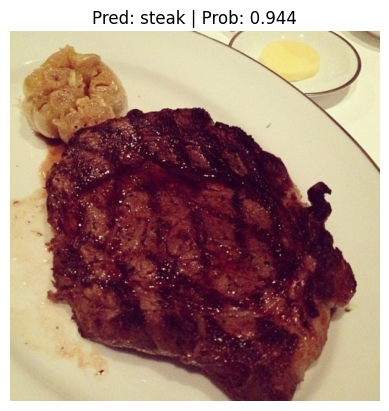

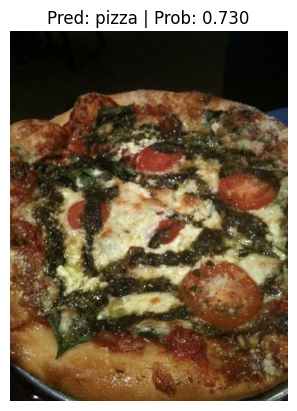

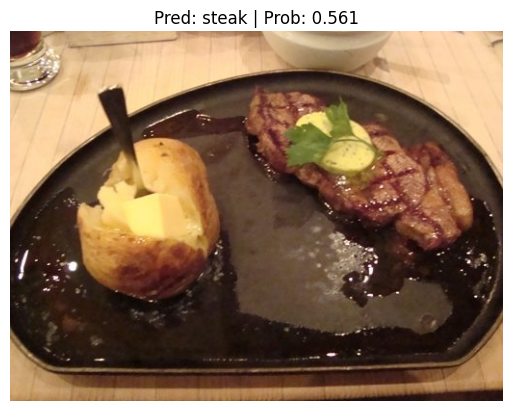

In [ ]:
from going_modular.going_modular.predictions import pred_and_plot_image
import random
num_images_to_plot = 3
test_image_path_list = list(Path("data/pizza_steak_sushi_20_percent/test").glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list,
                                       k = num_images_to_plot)
for image_path in test_image_path_sample:
  pred_and_plot_image(model = best_model,
                      image_path = image_path, class_names = class_names,
                      image_size=(224,224))

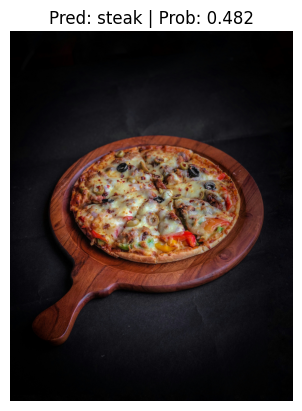

In [ ]:
import requests
custom_image_path = Path("data/sample.jpeg")

with open(custom_image_path, "wb") as f:
  request = requests.get("https://github.com/gaganWanjari/Pytorch/blob/main/sample_pizza.jpeg?raw=true")
  f.write(request.content)

pred_and_plot_image(best_model, image_path = custom_image_path,class_names =  class_names)